In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
import nltk
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn import preprocessing
from micromort.utils.classification_plotter import plot_classification_report

### Get the dataset

In [2]:
data_dump = pd.read_csv("../../data/annotator_data_dump_with_polarity")
data_dump = data_dump[data_dump.polarity != 9].reset_index(drop=True)
data_dump = data_dump.drop(['category'], axis=1).drop_duplicates()

IOError: File ../../data/annotator_data_dump_with_polarity does not exist

In [3]:
data_dump

,url,summary,title,polarity,e,text
0,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,Russian hackers said to have stolen US cyber s...,-1,0.0,WASHINGTON (REUTERS) - Russian government-back...
2,http://www.channelnewsasia.com/news/health/to-...,(Reuters Health) - The best way to get teens t...,"To grow teen athletes, let kids try lots of sp...",0,-1.0,LONDON: The best way to get teens to play spor...
3,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,Protests in Asia against Trump's decision on J...,-1,0.0,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...
5,http://www.asiaone.com/health/zika-virus-singa...,SINGAPORE - Analysis of the Zika virus found i...,Zika virus in Singapore likely from Asian stra...,-1,0.0,SINGAPORE - Analysis of the Zika virus found i...
6,http://www.asiaone.com/health/good-or-bad-look...,"Canola oil, which is extracted from the seeds ...",Good or bad? A look at myths and facts about c...,-1,1.0,SINGAPORE - Canola oil used to be the healthy ...
7,http://www.asiaone.com/china/china-punishes-of...,SHANGHAI - China has punished officials in the...,China punishes officials for tampering with sm...,-1,0.0,Beijing plans to establish an environmental po...
9,http://www.asiaone.com/digital/upcoming-featur...,Return of the Start menu: Windows 10 brings ba...,The upcoming features in Windows 10,0,0.0,Return of the Start menu: Windows 10 brings ba...
10,http://www.straitstimes.com/world/middle-east/...,RIYADH (AFP) - Saudi Arabian women will be abl...,Saudi women will also be allowed to drive moto...,1,0.0,RIYADH (AFP) - Saudi Arabian women will be abl...
11,http://www.straitstimes.com/asia/se-asia/zodia...,KUALA LUMPUR - Chinese across the world are pr...,"Zodiac dog, pig go missing for Chinese New Yea...",-1,0.0,KUALA LUMPUR - Chinese across the world are pr...
12,http://www.asiaone.com/health/men-face-higher-...,"For men, the risk of HPV-driven cancers of the...",Men face higher risk of cancers linked to oral...,-1,0.0,WASHINGTON - Men are twice as likely as women ...


In [39]:
data = data_dump[["text", "polarity"]].dropna()

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(data["text"].values, data["polarity"].values)

## Data pre processing

In [41]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/mannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1368,), (1368,), (456,), (456,))

In [43]:
def text_prepare(texts):
    processed_texts = []
    for i, text in enumerate(texts):
        _text = text.lower()
        _text = re.compile('[/(){}\[\]\|@,;]').sub(r' ', _text)
        _text = re.compile('[^0-9a-z #+_]').sub(r'', _text)
        _text = ' '.join([word for word in _text.split() if word not in set(stopwords.words('english'))])
        processed_texts.append(_text)
    return processed_texts

def splitAndProcess(X, func, num_partitions, num_cores=4):
    df_split = np.array_split(np.array(X), num_partitions)
    pool = Pool(num_cores)
    X = np.concatenate(pool.map(func, df_split))
    pool.close()
    pool.join()
    return X

In [8]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_test, text_prepare, 8, 8)

In [9]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [10]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [11]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

('number of features: ', (1368, 71487), (456, 71487))


## Train:

In [12]:
#mlb = MultiLabelBinarizer(classes=[-1,0,1])
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(Y_train)
y_val = lb.fit_transform(Y_test)

### LR

In [13]:
LR_classifier = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
LR_classifier.fit(X_train_tfidf, y_train)
accuracy_score(y_val, LR_classifier.predict(X_val_tfidf))

0.581140350877193

/home/mannu/code/work/micromort/virtualenv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


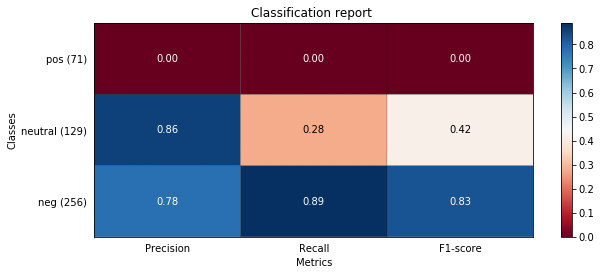

In [16]:
plot_classification_report(sklearn.metrics.classification_report(y_val, LR_classifier.predict(X_val_tfidf), target_names=["neg", "neutral", "pos"]))

### SVM:

In [17]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf)
accuracy_score(y_val, y_pred_svm)

0.6228070175438597

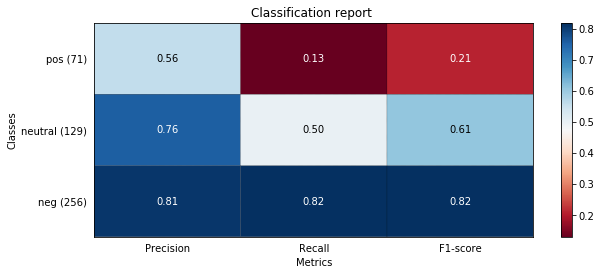

In [18]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names=["neg", "neutral", "pos"]))

## Feature importance: (Using LR classifier)

In [16]:
tfidf_vocab = tfidf_vectorizer.vocabulary_
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
def show_wordcloud(source, max_words=50):
    
    wordcloud = WordCloud(scale=4, max_words=1000)
    if type(source).__name__ == 'str' or type(source).__name__ == 'unicode':
        wordcloud.generate_from_text(source)
    else:
        wordcloud.generate_from_frequencies(source)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, number_of_words = 20):
    cof = classifier.estimators_[[-1,0,1].index(tag)].coef_
    top_negative_words = {}
    top_positive_words = {}
    for k in np.argsort(-cof[0])[:number_of_words]:
        top_positive_words[tfidf_reversed_vocab[k]] = cof[0][k]
        
    for k in np.argsort(cof[0])[:number_of_words]:
        top_negative_words[tfidf_reversed_vocab[k]] = cof[0][k]
        
    print("Tag:\t" + str(tag))
    print('positive words:\t{}'.format(', '.join(top_positive_words)))
    show_wordcloud(top_positive_words)
    print('negative words:\t{}\n'.format(', '.join(top_negative_words)))
    show_wordcloud(top_negative_words)

Tag:	-1
positive words:	said, police, government, fire, official, incident, infection, nea, high, death, attack, accused, accounts, jerusalem, found, plastic, data, children, condition, man


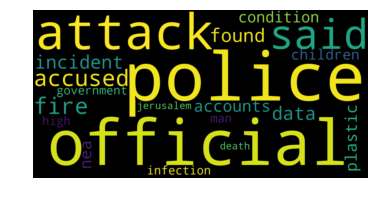

negative words:	development, hair, training, victory, apple, malaysia, club, app, sports, project, tv, game, breast, digital, talks, new, programme, breast cancer, exercise, first



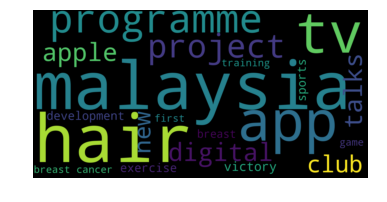

Tag:	0
positive words:	serve, set, age, users, samsung, career, winfrey, museum, mr, nutritional, ong, first, zoo, tv, music, digital, one, meals, galaxy, apple


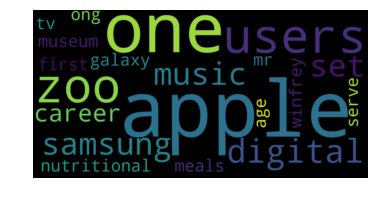

negative words:	fire, school, said, police, indian, cancer, government, students, internet, agency, blink, environment, society, train, health, treatment, child, japan, surgery, official



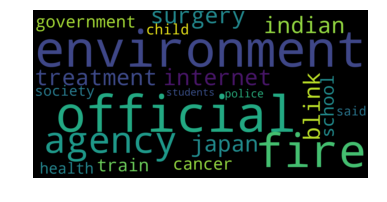

Tag:	1
positive words:	fuels, cakes, glaucoma, methods, schizophrenia, technology, nabin, training, game, foster, cardiac arrest, breast, team, device, security, women, breast cancer, hsieh, vision, cognitive


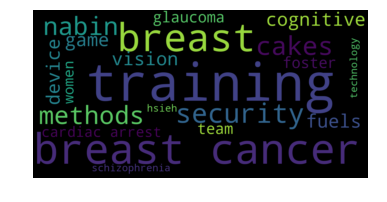

negative words:	case, kids, patient, apple, people, pain, global, doctor, infection, one, high, incident, spread, products, south, report, rare, data, condition, diabetes



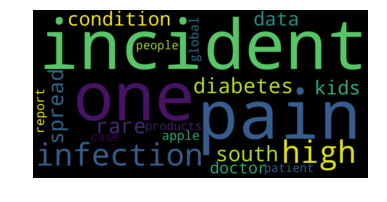

In [23]:
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
for key in [-1,0,1]:
    print_words_for_tag(classifier, key, [-1,0,1], tfidf_reversed_vocab)

### Classification report

In [24]:
from micromort.utils.classification_plotter import plot_classification_report

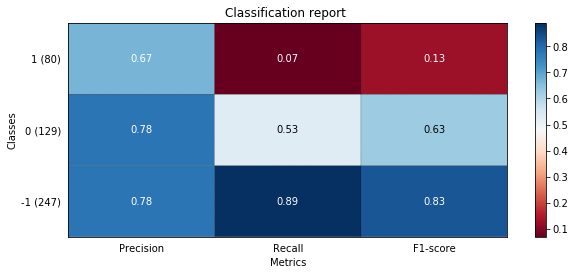

In [25]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names= [ "-1","0","1"]))

# Train on title

In [19]:
data = data_dump[["title", "polarity"]].dropna()

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(data["title"].values, data["polarity"].values)

## Data pre processing

In [21]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/mannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1385,), (1385,), (462,), (462,))

In [23]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_test, text_prepare, 8, 8)

In [24]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [25]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [26]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

('number of features: ', (1385, 2227), (462, 2227))


## Train:

In [27]:
#mlb = MultiLabelBinarizer(classes=[-1,0,1])
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(Y_train)
y_val = lb.fit_transform(Y_test)

### LR

In [28]:
LR_classifier = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
LR_classifier.fit(X_train_tfidf, y_train)
accuracy_score(y_val, LR_classifier.predict(X_val_tfidf))

0.46320346320346323

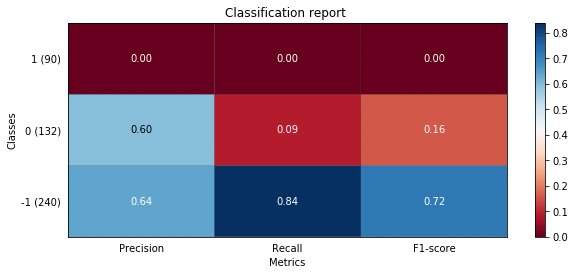

In [29]:
plot_classification_report(sklearn.metrics.classification_report(y_val, LR_classifier.predict(X_val_tfidf), target_names= [ "-1","0","1"]))

### SVM:

In [33]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(X_train_tfidf, y_train).predict(X_val_tfidf)
accuracy_score(y_val, y_pred_svm)

0.4935064935064935

### Classification report

In [34]:
from micromort.utils.classification_plotter import plot_classification_report

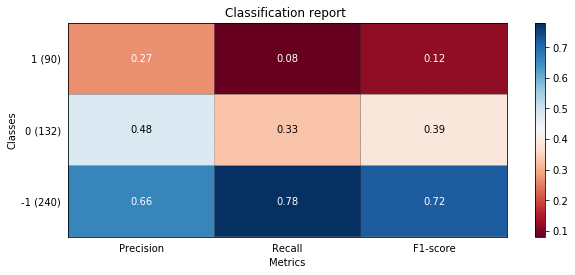

In [35]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names= [ "-1","0","1"]))

## XGBoost

In [44]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
# If you want to avoid the OneVsRestClassifier magic switch
# from sklearn.multioutput import MultiOutputClassifier

clf_multilabel = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)

In [45]:
clf_multilabel.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=-1)

### On title

In [46]:
y_val_predicted_labels_tfidf = clf_multilabel.predict(X_val_tfidf)
accuracy_score(y_val, y_val_predicted_labels_tfidf)

0.487012987012987

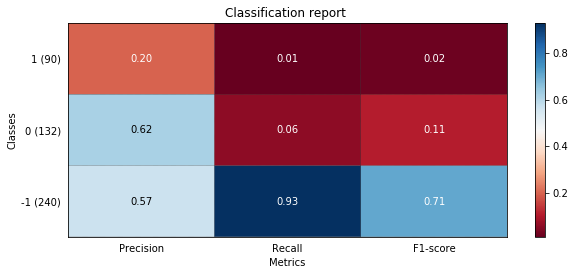

In [47]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_val_predicted_labels_tfidf, target_names= [ "-1","0","1"]))

### On body:

In [48]:
y_val_predicted_labels_tfidf = clf_multilabel.predict(X_val_tfidf)
accuracy_score(y_val, y_val_predicted_labels_tfidf)

0.487012987012987

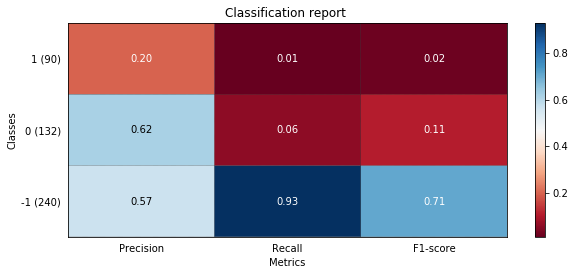

In [50]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_val_predicted_labels_tfidf, target_names= [ "-1","0","1"]))

## try with word embeddings:

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import gensim



import nltk
from collections import defaultdict

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from micromort.datasets.risk_dataset import RiskDataset
from gensim.models import KeyedVectors

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [52]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.KeyedVectors.load_word2vec_format("/home/mannu/code/work/micromort/data/wordEmbeddings/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin", binary=True)
        #model = KeyedVectors.load_word2vec_format("/home/mannu/data/wordEmbeddings/word2v.txt")
        #gensim.models.Word2Vec.load("/home/mannu/data/wordEmbeddings/word2v.txt")
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [53]:
w2v = get_word2vec("","/home/mannu/code/work/micromort/data/wordEmbeddings/glove.6B.300d.txt")

Found /home/mannu/code/work/micromort/data/wordEmbeddings/glove.6B.300d.txt


In [54]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [55]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [72]:
data = data_dump[["title", "polarity"]].dropna()

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(data["title"].values, data["polarity"].values)

## Data pre processing

In [75]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/mannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1385,), (1385,), (462,), (462,))

In [77]:
X_train = splitAndProcess(X_train, text_prepare, 8, 8)
X_val = splitAndProcess(X_test, text_prepare, 8, 8)

In [78]:
tfidf_vectorizer = TfidfVectorizer(min_df = .001, ngram_range=(1,5), token_pattern='(\S+)').fit(X_train)

def tfidf_features(X):
    return tfidf_vectorizer.transform(X)

In [79]:
X_train_tfidf = tfidf_features(X_train)
X_val_tfidf = tfidf_features(X_val)

In [80]:
print("number of features: ", X_train_tfidf.shape, X_val_tfidf.shape)

('number of features: ', (1385, 2213), (462, 2213))


In [81]:
mean_embedded_train = mean_embedding_vectorizer.fit_transform(X_train)
mean_embedded_test = mean_embedding_vectorizer.fit_transform(X_val)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [82]:
print(mean_embedded_train.shape, mean_embedded_test.shape, Y_train.shape)

((1385, 300), (462, 300), (1385,))


In [83]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(mean_embedded_train, Y_train).predict(mean_embedded_test)
accuracy_score(Y_test, y_pred_svm)

0.658008658008658

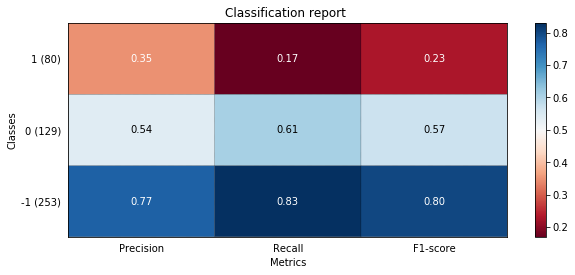

In [85]:
plot_classification_report(sklearn.metrics.classification_report(Y_test, y_pred_svm, target_names= [ "-1","0","1"]))

### Try tfidf embeddings

In [86]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)



class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.syn0[0])
        print(self.dim)

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [87]:
tfidf_embedding_vectorizer = TfidfEmbeddingVectorizer(w2v)
tfidf_embedding_vectorizer.fit(X_train)
tfidf_embedded_train = tfidf_embedding_vectorizer.transform(X_train)
tfidf_embedded_test = tfidf_embedding_vectorizer.transform(X_val)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


300


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [88]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(tfidf_embedded_train, Y_train).predict(tfidf_embedded_test)
accuracy_score(Y_test, y_pred_svm)

0.6233766233766234

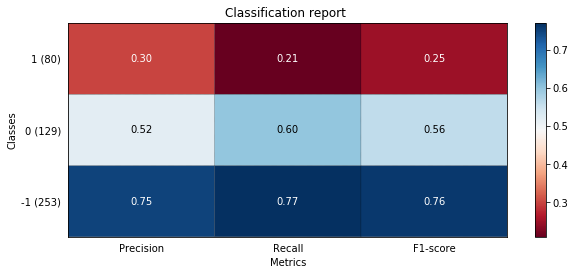

In [89]:
plot_classification_report(sklearn.metrics.classification_report(Y_test, y_pred_svm, target_names= [ "-1","0","1"]))